In [1]:
# 'standard' imports. Not all of these are used or needed
from astropy.io import fits
from astropy.table import Table
from astropy.io.fits import getdata
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
import fitsio
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import math
from multiprocessing import Pool
from pandas import DataFrame

In [2]:
# basic constants needed for script
nSides = 2048
channels = ['G', 'R', 'I', 'Z']
channel = 'I'
bins = np.linspace(16,28)
centers = (bins[1:] + bins[:-1]) / 2.0

In [3]:
#file information
dir_name = '/home/s1/djsuson/data/'
d2h_combo_file_name = 'delve2hsc_v2.fits'
h2d_combo_file_name = 'hsc2delve_v2.fits'
delve_file_name = 'delve_overlap.fits'
hsc_file_name = 'hsc_overlap_v2.fits'

In [4]:
# read in data
base_combo_data = getdata(dir_name+d2h_combo_file_name, 1)
base_h2d_combo_data = getdata(dir_name+h2d_combo_file_name, 1)
base_delve_data = getdata(dir_name+delve_file_name, 1)
base_hsc_data = getdata(dir_name+hsc_file_name, 1)

/cvmfs/des.opensciencegrid.org/fnal/anaconda3/envs/des20a/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/des.opensciencegrid.org/fnal/anaconda3/envs/des20a/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


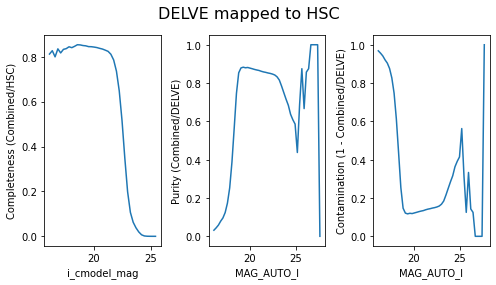

In [5]:
# look at delve mapping to hsc
combo_data = base_combo_data
delve_data = base_delve_data
hsc_data = base_hsc_data

# remove obviously invalid data
combo_data = combo_data[(combo_data[f'MAG_AUTO_{channel}'] < 90)]
combo_data = combo_data[np.isfinite(combo_data[f'{channel.lower()}_cmodel_mag'])]
delve_data = delve_data[delve_data[f'MAG_AUTO_{channel}'] < 90]
hsc_data = hsc_data[np.isfinite(hsc_data[f'{channel.lower()}_cmodel_mag'])]

# pixelize data
combo_pixels = hp.ang2pix(nSides, combo_data['RA'], combo_data['DEC'], lonlat=True)
delve_pixels = hp.ang2pix(nSides, delve_data['RA'], delve_data['DEC'], lonlat=True)
hsc_pixels = hp.ang2pix(nSides, hsc_data['ra'], hsc_data['dec'], lonlat=True)
pixel_list = np.unique(combo_pixels)

# select delve and hsc pixels that are also in combo pixels
sel_delve = np.in1d(delve_pixels, pixel_list)
sel_hsc = np.in1d(hsc_pixels, pixel_list)

# plot histograms
delve_hist, delve_edges = np.histogram(delve_data[sel_delve][f'MAG_AUTO_{channel}'], range=(16,28), bins=bins)
hsc_hist, hsc_edges = np.histogram(hsc_data[sel_hsc][f'{channel.lower()}_cmodel_mag'], range=(16,28), bins=bins)
delve_combo_hist, _ = np.histogram(combo_data[f'MAG_AUTO_{channel}'], range=(16,28), bins=bins)
hsc_combo_hist, _ = np.histogram(combo_data[f'{channel.lower()}_cmodel_mag'], range=(16,28), bins=bins)
delve_ratio = (delve_combo_hist / delve_hist).astype(float)
hsc_ratio = (hsc_combo_hist / hsc_hist).astype(float)

fig1, axs1 = plt.subplots(1, 3, figsize=(7,4))
fig1.suptitle('DELVE mapped to HSC', fontsize=16)

axs1[0].plot(centers, hsc_ratio)
axs1[0].set(xlabel=f'{channel.lower()}_cmodel_mag', ylabel='Completeness (Combined/HSC)')

axs1[1].plot(centers, delve_ratio)
axs1[1].set(xlabel=f'MAG_AUTO_{channel}', ylabel='Purity (Combined/DELVE)')

axs1[2].plot(centers, 1 - delve_ratio)
axs1[2].set(xlabel=f'MAG_AUTO_{channel}', ylabel='Contamination (1 - Combined/DELVE)')

fig1.tight_layout()
fig1.subplots_adjust(top=0.88)

/cvmfs/des.opensciencegrid.org/fnal/anaconda3/envs/des20a/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/des.opensciencegrid.org/fnal/anaconda3/envs/des20a/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


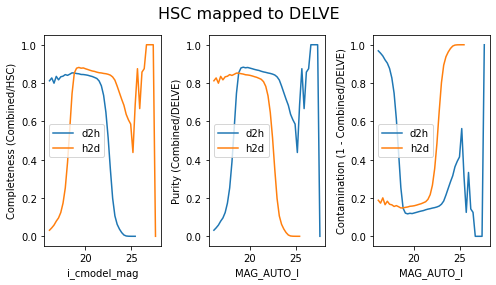

In [6]:
# look at hsc mapping to delve
del combo_data, delve_data, hsc_data
combo_data = base_h2d_combo_data
delve_data = base_delve_data
hsc_data = base_hsc_data

# remove obviously invalid data
combo_data = combo_data[(combo_data[f'MAG_AUTO_{channel}'] < 90)]
combo_data = combo_data[np.isfinite(combo_data[f'{channel.lower()}_cmodel_mag'])]
delve_data = delve_data[delve_data[f'MAG_AUTO_{channel}'] < 90]
hsc_data = hsc_data[np.isfinite(hsc_data[f'{channel.lower()}_cmodel_mag'])]

# pixelize data
combo_pixels = hp.ang2pix(nSides, combo_data['ra'], combo_data['dec'], lonlat=True)
delve_pixels = hp.ang2pix(nSides, delve_data['RA'], delve_data['DEC'], lonlat=True)
hsc_pixels = hp.ang2pix(nSides, hsc_data['ra'], hsc_data['dec'], lonlat=True)
pixel_list = np.unique(combo_pixels)

# select delve and hsc pixels that are also in combo pixels
sel_delve = np.in1d(delve_pixels, pixel_list)
sel_hsc = np.in1d(hsc_pixels, pixel_list)

# plot histograms
h2d_delve_hist, h2d_delve_edges = np.histogram(delve_data[sel_delve][f'MAG_AUTO_{channel}'], range=(16,28), bins=bins)
h2d_hsc_hist, h2d_hsc_edges = np.histogram(hsc_data[sel_hsc][f'{channel.lower()}_cmodel_mag'], range=(16,28), bins=bins)
h2d_delve_combo_hist, _ = np.histogram(combo_data[f'MAG_AUTO_{channel}'], range=(16,28), bins=bins)
h2d_hsc_combo_hist, _ = np.histogram(combo_data[f'{channel.lower()}_cmodel_mag'], range=(16,28), bins=bins)
h2d_delve_ratio = (h2d_delve_combo_hist / h2d_delve_hist).astype(float)
h2d_hsc_ratio = (h2d_hsc_combo_hist / h2d_hsc_hist).astype(float)

fig3, axs3 = plt.subplots(1,3, figsize=(7,4))
fig3.suptitle('HSC mapped to DELVE', fontsize=16)

axs3[0].plot(centers, hsc_ratio, label='d2h')
axs3[0].plot(centers, h2d_delve_ratio, label='h2d')
axs3[0].set(xlabel=f'{channel.lower()}_cmodel_mag', ylabel='Completeness (Combined/HSC)')
axs3[0].legend()

axs3[1].plot(centers, delve_ratio, label='d2h')
axs3[1].plot(centers, h2d_hsc_ratio, label='h2d')
axs3[1].set(xlabel=f'MAG_AUTO_{channel}', ylabel='Purity (Combined/DELVE)')
axs3[1].legend()

axs3[2].plot(centers, 1 - delve_ratio, label='d2h')
axs3[2].plot(centers, 1 - h2d_hsc_ratio, label='h2d')
axs3[2].set(xlabel=f'MAG_AUTO_{channel}', ylabel='Contamination (1 - Combined/DELVE)')
axs3[2].legend()

fig3.tight_layout()
fig3.subplots_adjust(top=0.88)

The size of the DELVE sample for channel G is  6376574
The size of the HSC sample for channgel G is  31754901
The size of the combined sample using the DELVE magnitudes for channel G is  5063258
The size of the combined sample using HSC magnitudes for channel G is  5063258
The size of the DELVE sample for channel R is  6713529
The size of the HSC sample for channgel R is  31157711
The size of the combined sample using the DELVE magnitudes for channel R is  5552100
The size of the combined sample using HSC magnitudes for channel R is  5552100


/cvmfs/des.opensciencegrid.org/fnal/anaconda3/envs/des20a/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


The size of the DELVE sample for channel I is  4062606
The size of the HSC sample for channgel I is  17996873
The size of the combined sample using the DELVE magnitudes for channel I is  3303895
The size of the combined sample using HSC magnitudes for channel I is  3303895


/cvmfs/des.opensciencegrid.org/fnal/anaconda3/envs/des20a/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/des.opensciencegrid.org/fnal/anaconda3/envs/des20a/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


The size of the DELVE sample for channel Z is  7490226
The size of the HSC sample for channgel Z is  32075062
The size of the combined sample using the DELVE magnitudes for channel Z is  6108970
The size of the combined sample using HSC magnitudes for channel Z is  6108970


/cvmfs/des.opensciencegrid.org/fnal/anaconda3/envs/des20a/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


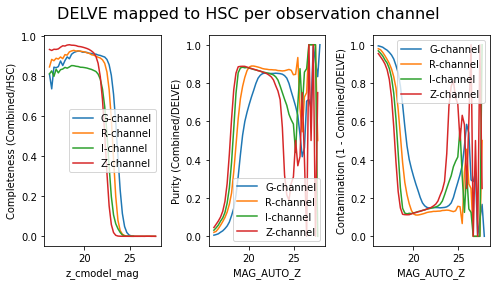

In [7]:
# plot histograms for delve mapping to hsc across all channels
fig4, axs4 = plt.subplots(1, 3, figsize=(7,4))
fig4.suptitle('DELVE mapped to HSC per observation channel', fontsize=16)

for single in channels:
    del combo_data, delve_data, hsc_data
    combo_data = base_combo_data
    delve_data = base_delve_data
    hsc_data = base_hsc_data

    # remove obviously invalid data
    combo_data = combo_data[(combo_data[f'MAG_AUTO_{single}'] < 90)]
    combo_data = combo_data[np.isfinite(combo_data[f'{single.lower()}_cmodel_mag'])]
    delve_data = delve_data[delve_data[f'MAG_AUTO_{single}'] < 90]
    hsc_data = hsc_data[np.isfinite(hsc_data[f'{single.lower()}_cmodel_mag'])]

    # pixelize data
    combo_pixels = hp.ang2pix(nSides, combo_data['RA'], combo_data['DEC'], lonlat=True)
    delve_pixels = hp.ang2pix(nSides, delve_data['RA'], delve_data['DEC'], lonlat=True)
    hsc_pixels = hp.ang2pix(nSides, hsc_data['ra'], hsc_data['dec'], lonlat=True)
    pixel_list = np.unique(combo_pixels)

    # select delve and hsc pixels that are also in combo pixels
    sel_delve = np.in1d(delve_pixels, pixel_list)
    sel_hsc = np.in1d(hsc_pixels, pixel_list)

    print(f'The size of the DELVE sample for channel {single} is ', len(delve_data[sel_delve][f'MAG_AUTO_{single}']))
    print(f'The size of the HSC sample for channgel {single} is ', len(hsc_data[sel_hsc][f'{single.lower()}_cmodel_mag']))
    print(f'The size of the combined sample using the DELVE magnitudes for channel {single} is ', len(combo_data[f'MAG_AUTO_{single}']))
    print(f'The size of the combined sample using HSC magnitudes for channel {single} is ', len(combo_data[f'{single.lower()}_cmodel_mag']))

    # plot histograms
    channel_delve_hist, channel_delve_edges = np.histogram(delve_data[sel_delve][f'MAG_AUTO_{single}'], range=(16,28), bins=bins)
    channel_hsc_hist, channel_hsc_edges = np.histogram(hsc_data[sel_hsc][f'{single.lower()}_cmodel_mag'], range=(16,28), bins=bins)
    channel_delve_combo_hist, _ = np.histogram(combo_data[f'MAG_AUTO_{single}'], range=(16,28), bins=bins)
    channel_hsc_combo_hist, _ = np.histogram(combo_data[f'{single.lower()}_cmodel_mag'], range=(16,28), bins=bins)
    channel_delve_ratio = (channel_delve_combo_hist / channel_delve_hist).astype(float)
    channel_hsc_ratio = (channel_hsc_combo_hist / channel_hsc_hist).astype(float)

    axs4[0].plot(centers, channel_hsc_ratio, label=f'{single}-channel')
    axs4[0].set(xlabel=f'{single.lower()}_cmodel_mag', ylabel='Completeness (Combined/HSC)')

    axs4[1].plot(centers, channel_delve_ratio, label=f'{single}-channel')
    axs4[1].set(xlabel=f'MAG_AUTO_{single}', ylabel='Purity (Combined/DELVE)')

    axs4[2].plot(centers, 1 - channel_delve_ratio, label=f'{single}-channel')
    axs4[2].set(xlabel=f'MAG_AUTO_{single}', ylabel='Contamination (1 - Combined/DELVE)')

axs4[0].legend()
axs4[1].legend()
axs4[2].legend()
fig4.tight_layout()
fig4.subplots_adjust(top=0.88)

/cvmfs/des.opensciencegrid.org/fnal/anaconda3/envs/des20a/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/des.opensciencegrid.org/fnal/anaconda3/envs/des20a/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


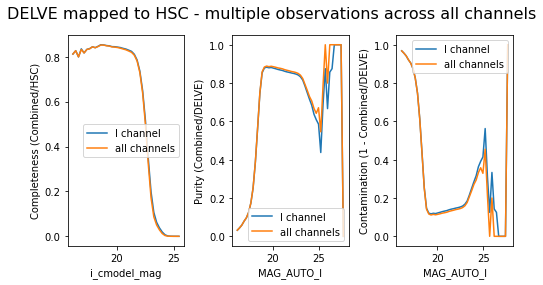

In [8]:
# filter based on total number of observations across all channels
# note that there does not appear to be an equivalent flag in the HSC data, so continue to use the full data set
del combo_data, delve_data, hsc_data
combo_data = base_combo_data
delve_data = base_delve_data
hsc_data = base_hsc_data

# remove obviously invalid data
combo_data = combo_data[(combo_data[f'MAG_AUTO_{channel}'] < 90)]
combo_data = combo_data[np.isfinite(combo_data[f'{channel.lower()}_cmodel_mag'])]
delve_data = delve_data[delve_data[f'MAG_AUTO_{channel}'] < 90]
hsc_data = hsc_data[np.isfinite(hsc_data[f'{channel.lower()}_cmodel_mag'])]

# do additional slices to data
combo_data = combo_data[(combo_data['NEPOCHS_I'] + combo_data['NEPOCHS_G'] \
                       + combo_data['NEPOCHS_R'] + combo_data['NEPOCHS_Z']) > 1]
delve_data = delve_data[(delve_data['NEPOCHS_I'] + delve_data['NEPOCHS_G'] + delve_data['NEPOCHS_R'] \
                       + delve_data['NEPOCHS_Z']) > 1]

# pixelize data
combo_pixels = hp.ang2pix(nSides, combo_data['RA'], combo_data['DEC'], lonlat=True)
delve_pixels = hp.ang2pix(nSides, delve_data['RA'], delve_data['DEC'], lonlat=True)
hsc_pixels = hp.ang2pix(nSides, hsc_data['ra'], hsc_data['dec'], lonlat=True)
pixel_list = np.unique(combo_pixels)

# select delve and hsc pixels that are also in combo pixels
sel_delve = np.in1d(delve_pixels, pixel_list)
sel_hsc = np.in1d(hsc_pixels, pixel_list)

# plot histograms
mchan_delve_hist, mchan_delve_edges = np.histogram(delve_data[sel_delve][f'MAG_AUTO_{channel}'], range=(16,28), bins=bins)
mchan_hsc_hist, mchan_hsc_edges = np.histogram(hsc_data[sel_hsc][f'{channel.lower()}_cmodel_mag'], range=(16,28), bins=bins)
mchan_delve_combo_hist, _ = np.histogram(combo_data[f'MAG_AUTO_{channel}'], range=(16,28), bins=bins)
mchan_hsc_combo_hist, _ = np.histogram(combo_data[f'{channel.lower()}_cmodel_mag'], range=(16,28), bins=bins)
mchan_delve_ratio = (mchan_delve_combo_hist / mchan_delve_hist).astype(float)
mchan_hsc_ratio = (mchan_hsc_combo_hist / mchan_hsc_hist).astype(float)

fig5, axs5 = plt.subplots(1, 3, figsize=(7,4))
fig5.suptitle('DELVE mapped to HSC - multiple observations across all channels', fontsize=16)

axs5[0].plot(centers, hsc_ratio, label=f'{channel} channel')
axs5[0].plot(centers, mchan_hsc_ratio, label='all channels')
axs5[0].set(xlabel=f'{channel.lower()}_cmodel_mag', ylabel='Completeness (Combined/HSC)')
axs5[0].legend()

axs5[1].plot(centers, delve_ratio, label=f'{channel} channel')
axs5[1].plot(centers, mchan_delve_ratio, label='all channels')
axs5[1].set(xlabel=f'MAG_AUTO_{channel}', ylabel='Purity (Combined/DELVE)')
axs5[1].legend()

axs5[2].plot(centers, 1 - delve_ratio, label=f'{channel} channel')
axs5[2].plot(centers, 1 - mchan_delve_ratio, label='all channels')
axs5[2].set(xlabel=f'MAG_AUTO_{channel}', ylabel='Contamination (1 - Combined/DELVE)')
axs5[2].legend()

fig5.tight_layout()
fig5.subplots_adjust(top=0.88)

/cvmfs/des.opensciencegrid.org/fnal/anaconda3/envs/des20a/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/des.opensciencegrid.org/fnal/anaconda3/envs/des20a/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/des.opensciencegrid.org/fnal/anaconda3/envs/des20a/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


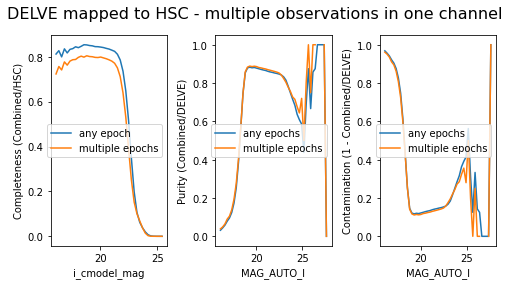

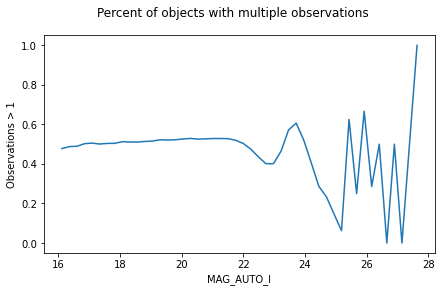

In [9]:
#filter based on number of observations across single channel greater than one
# note that there does not appear to be an equivalent flag in the HSC data, so continue to use the full data set
del combo_data, delve_data, hsc_data
combo_data = base_combo_data
delve_data = base_delve_data
hsc_data = base_hsc_data

# remove obviously invalid data
combo_data = combo_data[(combo_data[f'MAG_AUTO_{channel}'] < 90)]
combo_data = combo_data[np.isfinite(combo_data[f'{channel.lower()}_cmodel_mag'])]
delve_data = delve_data[delve_data[f'MAG_AUTO_{channel}'] < 90]
hsc_data = hsc_data[np.isfinite(hsc_data[f'{channel.lower()}_cmodel_mag'])]

# do additional slices to data
combo_data = combo_data[combo_data['NEPOCHS_I'] > 1]
delve_data = delve_data[delve_data['NEPOCHS_I'] > 1]

# pixelize data
combo_pixels = hp.ang2pix(nSides, combo_data['RA'], combo_data['DEC'], lonlat=True)
delve_pixels = hp.ang2pix(nSides, delve_data['RA'], delve_data['DEC'], lonlat=True)
pixel_list = np.unique(combo_pixels)
sel_delve = np.in1d(delve_pixels, pixel_list)
sel_hsc = np.in1d(hsc_pixels, pixel_list)

# plot histograms
multi_delve_hist, multi_delve_edges = np.histogram(delve_data[sel_delve][f'MAG_AUTO_{channel}'], range=(16,28), bins=bins)
multi_hsc_hist, multi_hsc_edges = np.histogram(hsc_data[sel_hsc][f'{channel.lower()}_cmodel_mag'], range=(16,28), bins=bins)
multi_delve_combo_hist, _ = np.histogram(combo_data[f'MAG_AUTO_{channel}'], range=(16,28), bins=bins)
multi_hsc_combo_hist, _ = np.histogram(combo_data[f'{channel.lower()}_cmodel_mag'], range=(16,28), bins=bins)
multi_delve_ratio = (multi_delve_combo_hist / multi_delve_hist).astype(float)
multi_hsc_ratio = (multi_hsc_combo_hist / multi_hsc_hist).astype(float)

fig6, axs6 = plt.subplots(1, 3, figsize=(7,4))
fig6.suptitle('DELVE mapped to HSC - multiple observations in one channel', fontsize=16)

axs6[0].plot(centers, hsc_ratio, label='any epoch')
axs6[0].plot(centers, multi_hsc_ratio, label='multiple epochs')
axs6[0].set(xlabel=f'{channel.lower()}_cmodel_mag', ylabel='Completeness (Combined/HSC)')
axs6[0].legend()

axs6[1].plot(centers, delve_ratio, label='any epochs')
axs6[1].plot(centers, multi_delve_ratio, label='multiple epochs')
axs6[1].set(xlabel=f'MAG_AUTO_{channel}', ylabel='Purity (Combined/DELVE)')
axs6[1].legend()

axs6[2].plot(centers, 1 - delve_ratio, label='any epochs')
axs6[2].plot(centers, 1 - multi_delve_ratio, label='multiple epochs')
axs6[2].set(xlabel=f'MAG_AUTO_{channel}', ylabel='Contamination (1 - Combined/DELVE)')
axs6[2].legend()

fig6.tight_layout()
fig6.subplots_adjust(top=0.88)

obs_ratio = (multi_delve_hist / delve_hist).astype(float)
fig7 = plt.figure(figsize=(7,4))
plt.plot(centers, obs_ratio)
plt.xlabel(f'MAG_AUTO_{channel}')
plt.ylabel('Observations > 1')
plt.suptitle('Percent of objects with multiple observations')
plt.show()

/cvmfs/des.opensciencegrid.org/fnal/anaconda3/envs/des20a/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/des.opensciencegrid.org/fnal/anaconda3/envs/des20a/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


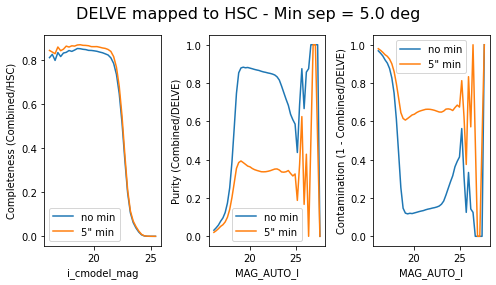

In [10]:
# apply cut on hsc to remove neighbors within 5 arcsec
min_sep = 5.0 * u.arcsec

del combo_data, delve_data, hsc_data
combo_data = base_combo_data
delve_data = base_delve_data
hsc_data = base_hsc_data

# remove obviously invalid data
combo_data = combo_data[(combo_data[f'MAG_AUTO_{channel}'] < 90)]
combo_data = combo_data[np.isfinite(combo_data[f'{channel.lower()}_cmodel_mag'])]
delve_data = delve_data[delve_data[f'MAG_AUTO_{channel}'] < 90]
hsc_data = hsc_data[np.isfinite(hsc_data[f'{channel.lower()}_cmodel_mag'])]

# do additional slices to data
hsc_sky = SkyCoord(ra=hsc_data['ra']*u.degree, dec=hsc_data['dec']*u.degree)
idx, d2d, d3d = match_coordinates_sky(hsc_sky, hsc_sky, nthneighbor=2)
sep_constraint = d2d > min_sep
removed_ids = hsc_data['object_id'][~sep_constraint]
hsc_data = hsc_data[sep_constraint]
sel_combo = np.in1d(combo_data['object_id'], removed_ids)
combo_data = combo_data[~sel_combo]

SNR = 10.0
delta_mag = 1.087 / SNR
SNR_constraint = hsc_data[f'{channel.lower()}_cmodel_magsigma'] < delta_mag
removed_ids = hsc_data['object_id'][~SNR_constraint]
hsc_data = hsc_data[SNR_constraint]
sel_combo = np.in1d(combo_data['object_id'], removed_ids)
combo_data = combo_data[~sel_combo]

# pixelize data
combo_pixels = hp.ang2pix(nSides, combo_data['RA'], combo_data['DEC'], lonlat=True)
delve_pixels = hp.ang2pix(nSides, delve_data['RA'], delve_data['DEC'], lonlat=True)
hsc_pixels = hp.ang2pix(nSides, hsc_data['ra'], hsc_data['dec'], lonlat=True)
pixel_list = np.unique(combo_pixels)

# select delve and hsc pixels that are also in combo pixels
sel_delve = np.in1d(delve_pixels, pixel_list)
sel_hsc = np.in1d(hsc_pixels, pixel_list)

# plot histograms
dist_delve_hist, dist_delve_edges = np.histogram(delve_data[sel_delve][f'MAG_AUTO_{channel}'], range=(16,28), bins=bins)
dist_hsc_hist, dist_hsc_edges = np.histogram(hsc_data[sel_hsc][f'{channel.lower()}_cmodel_mag'], range=(16,28), bins=bins)
dist_delve_combo_hist, _ = np.histogram(combo_data[f'MAG_AUTO_{channel}'], range=(16,28), bins=bins)
dist_hsc_combo_hist, _ = np.histogram(combo_data[f'{channel.lower()}_cmodel_mag'], range=(16,28), bins=bins)
dist_delve_ratio = (dist_delve_combo_hist / dist_delve_hist).astype(float)
dist_hsc_ratio = (dist_hsc_combo_hist / dist_hsc_hist).astype(float)

fig8, axs8 = plt.subplots(1, 3, figsize=(7,4))
fig8.suptitle('DELVE mapped to HSC - Min sep = 5.0 deg', fontsize=16)

axs8[0].plot(centers, hsc_ratio, label='no min')
axs8[0].plot(centers, dist_hsc_ratio, label='5" min')
axs8[0].set(xlabel=f'{channel.lower()}_cmodel_mag', ylabel='Completeness (Combined/HSC)')
axs8[0].legend()

axs8[1].plot(centers, delve_ratio, label='no min')
axs8[1].plot(centers, dist_delve_ratio, label='5" min')
axs8[1].set(xlabel=f'MAG_AUTO_{channel}', ylabel='Purity (Combined/DELVE)')
axs8[1].legend()

axs8[2].plot(centers, 1 - delve_ratio, label='no min')
axs8[2].plot(centers, 1 - dist_delve_ratio, label='5" min')
axs8[2].set(xlabel=f'MAG_AUTO_{channel}', ylabel='Contamination (1 - Combined/DELVE)')
axs8[2].legend()

fig8.tight_layout()
fig8.subplots_adjust(top=0.88)

The size of the DELVE sample for channel G is  6352792
The size of the HSC sample for channgel G is  10465996
The size of the combined sample using the DELVE magnitudes for channel G is  2031071
The size of the combined sample using HSC magnitudes for channel G is  2031071
The size of the DELVE sample for channel R is  6696636
The size of the HSC sample for channgel R is  10284846
The size of the combined sample using the DELVE magnitudes for channel R is  2211960
The size of the combined sample using HSC magnitudes for channel R is  2211960


/cvmfs/des.opensciencegrid.org/fnal/anaconda3/envs/des20a/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


The size of the DELVE sample for channel I is  4047493
The size of the HSC sample for channgel I is  6052664
The size of the combined sample using the DELVE magnitudes for channel I is  1352477
The size of the combined sample using HSC magnitudes for channel I is  1352477


/cvmfs/des.opensciencegrid.org/fnal/anaconda3/envs/des20a/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/des.opensciencegrid.org/fnal/anaconda3/envs/des20a/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


The size of the DELVE sample for channel Z is  7475262
The size of the HSC sample for channgel Z is  10600813
The size of the combined sample using the DELVE magnitudes for channel Z is  2376827
The size of the combined sample using HSC magnitudes for channel Z is  2376827


/cvmfs/des.opensciencegrid.org/fnal/anaconda3/envs/des20a/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


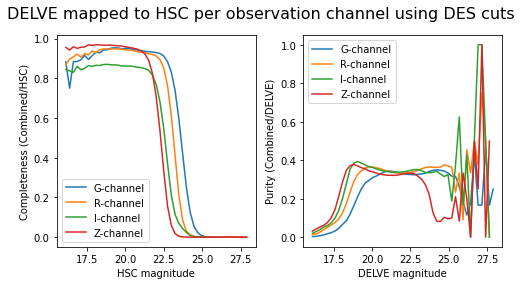

In [12]:
# plot histograms for delve mapping to hsc across all channels
fig9, axs9 = plt.subplots(1, 2, figsize=(7,4))
fig9.suptitle('DELVE mapped to HSC per observation channel using DES cuts', fontsize=16)

for single in channels:
    del combo_data, delve_data, hsc_data
    combo_data = base_combo_data
    delve_data = base_delve_data
    hsc_data = base_hsc_data

    # remove obviously invalid data
    combo_data = combo_data[(combo_data[f'MAG_AUTO_{single}'] < 90)]
    combo_data = combo_data[np.isfinite(combo_data[f'{single.lower()}_cmodel_mag'])]
    delve_data = delve_data[delve_data[f'MAG_AUTO_{single}'] < 90]
    hsc_data = hsc_data[np.isfinite(hsc_data[f'{single.lower()}_cmodel_mag'])]

    # do additional slices to data
    hsc_sky = SkyCoord(ra=hsc_data['ra']*u.degree, dec=hsc_data['dec']*u.degree)
    idx, d2d, d3d = match_coordinates_sky(hsc_sky, hsc_sky, nthneighbor=2)
    sep_constraint = d2d > min_sep
    removed_ids = hsc_data['object_id'][~sep_constraint]
    hsc_data = hsc_data[sep_constraint]
    sel_combo = np.in1d(combo_data['object_id'], removed_ids)
    combo_data = combo_data[~sel_combo]

    SNR = 10.0
    delta_mag = 1.087 / SNR
    SNR_constraint = hsc_data[f'{channel.lower()}_cmodel_magsigma'] < delta_mag
    removed_ids = hsc_data['object_id'][~SNR_constraint]
    hsc_data = hsc_data[SNR_constraint]
    sel_combo = np.in1d(combo_data['object_id'], removed_ids)
    combo_data = combo_data[~sel_combo]

    # pixelize data
    combo_pixels = hp.ang2pix(nSides, combo_data['RA'], combo_data['DEC'], lonlat=True)
    delve_pixels = hp.ang2pix(nSides, delve_data['RA'], delve_data['DEC'], lonlat=True)
    hsc_pixels = hp.ang2pix(nSides, hsc_data['ra'], hsc_data['dec'], lonlat=True)
    pixel_list = np.unique(combo_pixels)

    # select delve and hsc pixels that are also in combo pixels
    sel_delve = np.in1d(delve_pixels, pixel_list)
    sel_hsc = np.in1d(hsc_pixels, pixel_list)

    print(f'The size of the DELVE sample for channel {single} is ', len(delve_data[sel_delve][f'MAG_AUTO_{single}']))
    print(f'The size of the HSC sample for channgel {single} is ', len(hsc_data[sel_hsc][f'{single.lower()}_cmodel_mag']))
    print(f'The size of the combined sample using the DELVE magnitudes for channel {single} is ', len(combo_data[f'MAG_AUTO_{single}']))
    print(f'The size of the combined sample using HSC magnitudes for channel {single} is ', len(combo_data[f'{single.lower()}_cmodel_mag']))

    # plot histograms
    channel_delve_hist, channel_delve_edges = np.histogram(delve_data[sel_delve][f'MAG_AUTO_{single}'], range=(16,28), bins=bins)
    channel_hsc_hist, channel_hsc_edges = np.histogram(hsc_data[sel_hsc][f'{single.lower()}_cmodel_mag'], range=(16,28), bins=bins)
    channel_delve_combo_hist, _ = np.histogram(combo_data[f'MAG_AUTO_{single}'], range=(16,28), bins=bins)
    channel_hsc_combo_hist, _ = np.histogram(combo_data[f'{single.lower()}_cmodel_mag'], range=(16,28), bins=bins)
    channel_delve_ratio = (channel_delve_combo_hist / channel_delve_hist).astype(float)
    channel_hsc_ratio = (channel_hsc_combo_hist / channel_hsc_hist).astype(float)

    axs9[0].plot(centers, channel_hsc_ratio, label=f'{single}-channel')
    axs9[0].set(xlabel='HSC magnitude', ylabel='Completeness (Combined/HSC)')

    axs9[1].plot(centers, channel_delve_ratio, label=f'{single}-channel')
    axs9[1].set(xlabel=f'DELVE magnitude', ylabel='Purity (Combined/DELVE)')

axs9[0].legend()
axs9[1].legend()
fig9.tight_layout()
fig9.subplots_adjust(top=0.88)